In [1]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 
from recenterIR import recenter_ir

In [2]:
def reproject(dataset, pos):
    r = dataset.range.values
    t = dataset.azimuth.values * (np.pi / 180)
    R, T = np.meshgrid(r, t)
    newX, newY = R * np.cos(T), R * np.sin(T)

    range = np.arange(-3e+05, 3e+05, 300)
    gridX, gridY = np.meshgrid(range, range)
    gridded_data = scipy.interpolate.griddata((newX.flatten(), newY.flatten()), dataset.values.flatten(), (gridX.flatten(), gridY.flatten()), method='nearest')
    gridded_data = gridded_data.reshape(len(range), len(range)).transpose()

    radLat = dataset['latitude'].values
    radLon = dataset['longitude'].values
    lons = radLon + (gridX / (6371000 * np.cos(np.radians(radLat)))) * (180 / np.pi)
    lats = radLat + (gridY / 6371000) * (180 / np.pi)

    gridded = xr.Dataset(
        {
            'data': (('lons', 'lats'), gridded_data.reshape(gridX.shape))
        },
        coords={
            'lons': lons[0, :],
            'lats': lats[:, 0]
        }
    )

    size = 2
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size

    gridded = gridded.sel(lats = slice(minimglat, maximglat), lons = slice(minimglon, maximglon))

    lats = gridded.lats 
    lons = gridded.lons 
    lats, lons = np.meshgrid(lats, lons)

    REarth = 6371.0
    cphi = np.cos(np.radians(pos[0]))
    xkm = REarth * np.deg2rad(lons - pos[1]) * cphi
    ykm = REarth * np.deg2rad(lats - pos[0])

    plt.pcolormesh(xkm, ykm, gridded['data'].values)
    plt.show()

    # tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(gridded['data'], xkm, ykm, 10, lons, lats)
    # print(tc_center_lon, tc_center_lat)
    return gridded, lats, lons

In [3]:
def rePoPolar(dataset, lats, lons, center = None):
    dataset = dataset['data']

    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 200, 400)
    # tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)
    tBins = np.linspace(-np.pi, np.pi, 500)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)

    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.T.flatten(), (newX, newY), method='linear')

    polar = xr.Dataset(
        {
            'data': (('theta', 'r'), gridded_data.reshape(R.shape))
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return x, y, polar['data']


In [ ]:
def runv2(polar):
    data = np.array([np.nanmean(polar.values, axis = 0), np.nanstd(polar.values, axis = 0)])

    return data

In [5]:
def compute(ir_azi, ir_std):
    from scipy.ndimage import gaussian_filter1d

    ir_std = gaussian_filter1d(ir_std, sigma = 6)
    radii = np.arange(0, 500, 1)#polar.r.values

    diff = (np.diff(ir_std) / np.diff(radii))
    diff2_std = np.diff(diff) / np.diff(radii[1:])
    diff2 = np.diff(ir_azi) / np.diff(radii)
    diff2 = gaussian_filter1d(diff2, sigma = 2)

    min_ir_rad, min_ir_radARG = radii[np.nanargmin(ir_azi)], np.nanargmin(ir_azi)
    min_ir_temp = np.nanmin(ir_azi)
    try:
        eyerad, eyeradARG = radii[np.nanargmin(diff2[:np.nanargmin(ir_azi)])], np.nanargmin(diff2[:np.nanargmin(ir_azi)]) 
    except:
        eyerad, eyeradARG = 0, 0
    eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
    try:
        icdoedge, icdoedgeARG = (eyerad + min_ir_rad) / 2, int((eyeradARG + min_ir_radARG) / 2)
    except:
        icdoedge, icdoedgeARG = eyerad, eyeradARG
    tempArray = np.arange(0, 499, dtype = 'float32')

    temp = int(min_ir_radARG)
    thresh = min_ir_temp + 10
    zeroPoint = temp + np.where((ir_azi[temp:] > thresh))[0][0]
    ocdoedge, ocdoedgeARG = radii[zeroPoint], zeroPoint

    cdostd = np.nanmean(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    mincdostd = np.nanmin(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    maxcdostd = np.nanmax(ir_std[icdoedgeARG:int(ocdoedgeARG)])

    cdorad = ocdoedge - eyerad
    plt.show()

    return np.array([ocdoedge, eyerad, min_ir_temp, min_ir_rad, eyetemp, cdostd, mincdostd, maxcdostd])

In [6]:
def getStormParams(dataset, satt, year, month, day, time, loc, locType = 'first'):
    t = f'{year}-{str(month).zfill(2)}-{str(day).zfill(2)}_{time}'
    
    data, lats, lons = reproject(dataset, loc)
    print('reprojection susccessful')
    dataset.close()
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    
    print('centering successful')
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data['data'], xkm, ykm, 10, lons, lats)
        print('recentering successful')
        if (tc_center_lat, tc_center_lon) != (np.nan, np.nan):
            loc = (tc_center_lat, tc_center_lon)
            print('New Coordinates: ', tc_center_lat, tc_center_lon)

            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
        else:
            xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    processedData = runv2(polar)

    return processedData

In [7]:
from file import getGZ 
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime 

def getData(radar, year, month, day, time, loc):
    print(radar, year, month, day, time)
    bucket = f'unidata-nexrad-level2'    
    
    month = str(month).zfill(2)
    day = str(day).zfill(2)
    time = str(time).zfill(4)
    hour = time[0:2]
    min = time[2:4]

    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    prefix = f'{year}/{month}/{day}/{radar.upper()}'
    kwargs = {'Bucket': bucket,
                'Prefix': prefix}

    resp = s3_client.list_objects_v2(**kwargs)
    files = []
    mins = []
    for x in range(len(resp['Contents'])):
        key = resp['Contents'][x]['Key']
        if key.startswith(f'{prefix}/{radar.upper()}{year}{month}{day}_{hour}'):
            files.append(key)
            mins.append(int(key[31:33]) - int(min))

    # try:
    s3_client.download_file(bucket, files[np.argmin(np.array(mins)**2)], r"C:\Users\deela\Downloads\radarLoop.gz")
    fileName = files[np.argmin(np.array(mins)**2)]

    with xr.open_dataset(r"C:\Users\deela\Downloads\radarLoop.gz", engine = 'nexradlevel2', group = f'sweep_00') as data:
        params = getStormParams(data['DBZH'], None, year, month, day, time, loc, locType = 'Worst')

        data.close()
    # except Exception as e:
        # print(e)
        # params = np.array([[np.nan for x in range(0, 500)], [np.nan for x in range(0, 500)]])
        
    return params


In [8]:
import numpy as np

satt = 'KBYX'

year = 2022
month = 9
day = 27
times = [f"{h:02d}{m:02d}" for h in range(18, 24) for m in range(0, 60, 5)] + [f"{h:02d}{m:02d}" for h in range(0, 6) for m in range(0, 60, 5)] 
bPos = np.array([[0, 23.5, -83.3], [6, 24.4, -83.0], [8, 24.6, -82.9], [12, 25.2, -82.9]]).T
bTime = bPos[0]
bLat = bPos[1]
bLon = bPos[2]

bTarget = np.arange(0, 12, 5 / 60)
bLat = np.interp(bTarget, bTime, bLat)
bLon = np.interp(bTarget, bTime, bLon)

In [9]:
print(bTarget.shape, bLat.shape, bLon.shape, len(times))
# print(bTarget)
print(times)
print(list(bLat))

(144,) (144,) (144,) 144
['1800', '1805', '1810', '1815', '1820', '1825', '1830', '1835', '1840', '1845', '1850', '1855', '1900', '1905', '1910', '1915', '1920', '1925', '1930', '1935', '1940', '1945', '1950', '1955', '2000', '2005', '2010', '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2100', '2105', '2110', '2115', '2120', '2125', '2130', '2135', '2140', '2145', '2150', '2155', '2200', '2205', '2210', '2215', '2220', '2225', '2230', '2235', '2240', '2245', '2250', '2255', '2300', '2305', '2310', '2315', '2320', '2325', '2330', '2335', '2340', '2345', '2350', '2355', '0000', '0005', '0010', '0015', '0020', '0025', '0030', '0035', '0040', '0045', '0050', '0055', '0100', '0105', '0110', '0115', '0120', '0125', '0130', '0135', '0140', '0145', '0150', '0155', '0200', '0205', '0210', '0215', '0220', '0225', '0230', '0235', '0240', '0245', '0250', '0255', '0300', '0305', '0310', '0315', '0320', '0325', '0330', '0335', '0340', '0345', '0350', '0355', '0400', '0405'

0 :  2022 9 27 1800 23.5 -83.3
KBYX 2022 9 27 1800


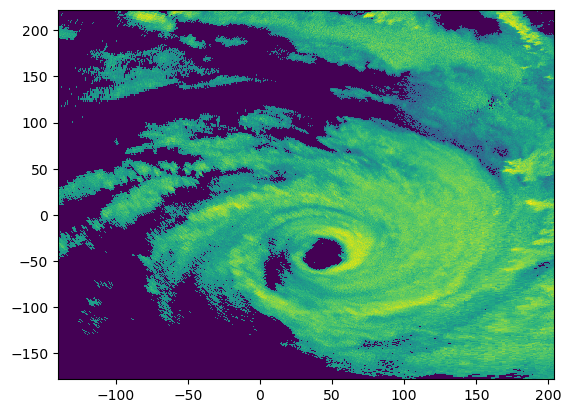

reprojection susccessful
centering successful
(500, 400) <xarray.DataArray 'data' (theta: 500, r: 400)> Size: 2MB
array([[ 20.78965726, -21.49234607,  29.34964513, ...,          nan,
                 nan,          nan],
       [ 20.78965726, -21.48420394,  29.39001384, ...,          nan,
                 nan,          nan],
       [ 20.78965726, -21.45977884,  29.4269617 , ...,          nan,
                 nan,          nan],
       ...,
       [ 20.78965726, -21.45977884,  29.25867134, ...,          nan,
                 nan,          nan],
       [ 20.78965726, -21.48420394,  29.30586198, ...,          nan,
                 nan,          nan],
       [ 20.78965726, -21.49234607,  29.34964513, ...,          nan,
                 nan,          nan]], shape=(500, 400))
Coordinates:
  * r        (r) float64 3kB 0.0 0.5013 1.003 1.504 ... 198.5 199.0 199.5 200.0
  * theta    (theta) float64 4kB -3.142 -3.129 -3.116 ... 3.116 3.129 3.142
Eye Temperature:  20.78965726453152 C
Min Temperat

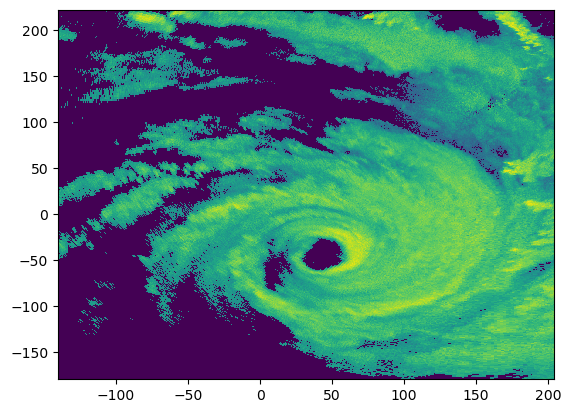

reprojection susccessful


In [ ]:
IRData = []
change = False
for x in range(0, len(bTarget)):
    time = times[x]
    if bTarget[x] >= 24 and change == False:
        change = True 
        day = day + 1
    loc = (bLat[x], bLon[x])
    print(x, ': ', year, month, day, time, float(bLat[x]), float(bLon[x]))
    data = getData(satt, year, month, day, time, loc)
    print('Eye Temperature: ', np.nanmax(data[0]), 'C\nMin Temperature: ', np.nanmin(data[0]), '\n')
    IRData.append(data)
print(IRData)

In [ ]:
# band = '09'
# WVData = []
# for x in range(0, len(bTarget)):
#     time = times[x]
#     loc = (bLat[x], bLon[x])
#     print(year, month, day, time, loc)
#     data = getData(satt, year, month, day, time, band, loc)
#     print(x, np.nanmax(data))
#     WVData.append(data)
# print(WVData)

In [ ]:
# print(np.array(IRData).shape, np.array(WVData).shape)
# allData = np.array(IRData) - np.array(WVData)
# print(allData.shape)
allData = np.array(IRData)# - np.array(WVData)
print(allData.shape)

(144, 2, 500)


In [ ]:
params = []
for x in range(len(allData)):
    try:
        l = compute(allData[x, 0], allData[x, 1])
    except:
        l = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    params.append(l)
params = np.array(params)

cdoRad = params[:, 0]
eyeRad = params[:, 1]
minTmp = params[:, 2]
minRad = params[:, 3]
eyeTmp = params[:, 4]
cdoStd = params[:, 5]
minStd = params[:, 6]
maxStd = params[:, 7]

500 144 144


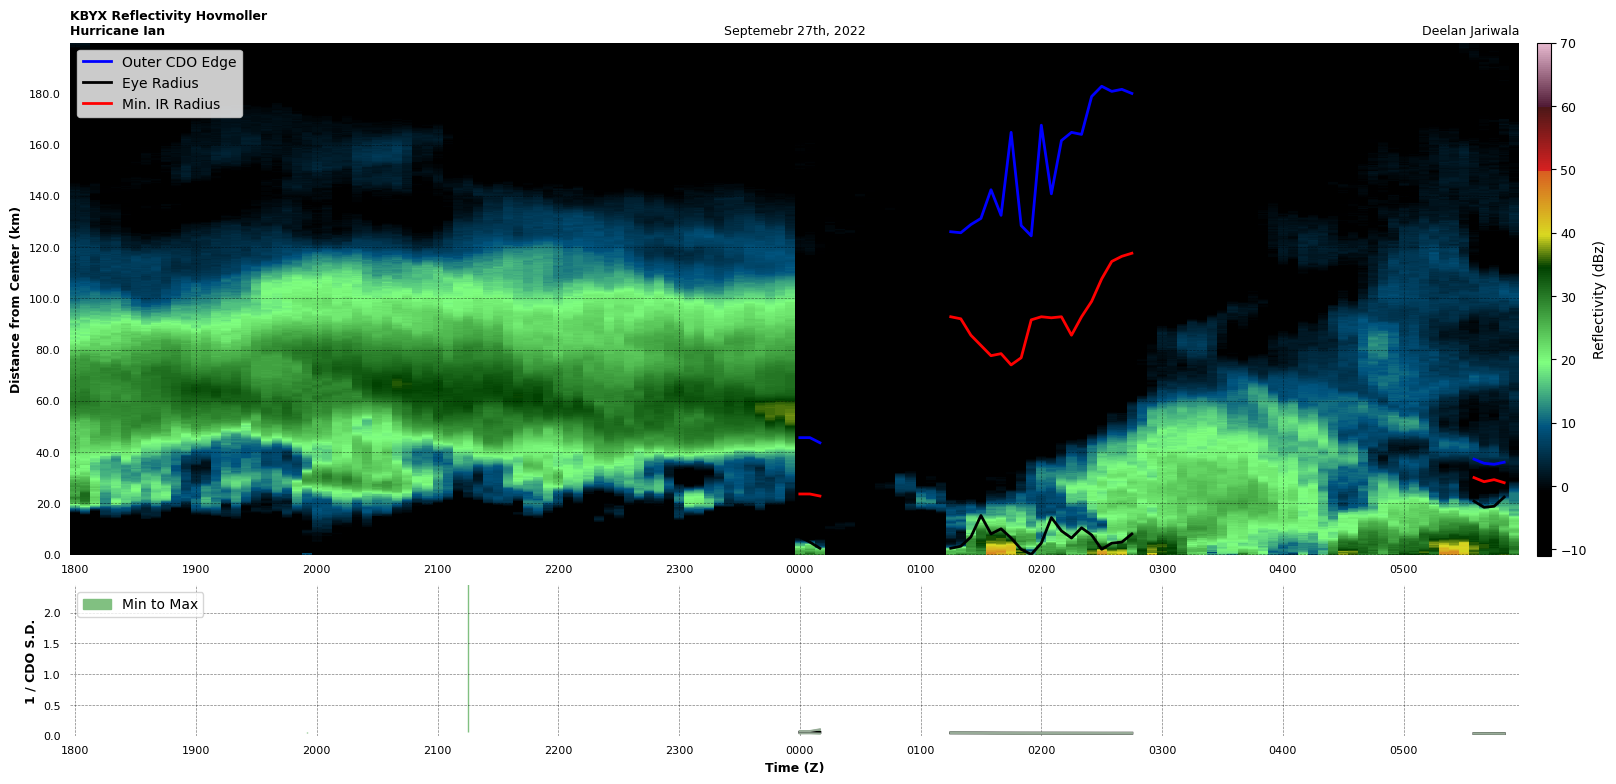

In [ ]:
data = allData[:, 0].T
v = 12

xLabels = [x / 2.5 for x in range(500) if x % 50 == 0]
yLabels = [times[x] for x in range(len(times)) if x % v == 0]
xCoord = np.arange(0, len(data[0]))
yCoord = np.arange(0, len(data)) 

import satcmaps as cmaps
cmap = 'ref'
cmap, vmax, vmin = cmaps.radtables[cmap.lower()]

fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(4, 1, wspace = 0, hspace = 0.2, right=0.93)

ax = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[3, 0], sharex = ax)

ax.set_frame_on(False)
ax2.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_ylabel('Distance from Center (km)', weight = 'bold', size = 9)
ax2.set_xlabel('Time (Z)', weight = 'bold', size = 9)
ax.set_xticks(np.arange(0, len(times), v))
ax.set_xticklabels(yLabels)
ax.set_yticks(np.arange(0, 500, 50))
ax.set_yticklabels(xLabels)
# ax.set_ylim(0, 250)

c = ax.pcolormesh(xCoord, yCoord, data, cmap = cmap, vmax = vmax, vmin = vmin)
# c = plt.contourf(np.arange(0, len(allData[0])), np.arange(0, len(allData)), allData, cmap = cmap, levels = np.arange(vmin, vmax + 1, 1))
print(len(data), len(data[0]), len(cdoRad))
ax.plot(xCoord, cdoRad, color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
ax.plot(xCoord, eyeRad, color = 'black', linewidth = 2, label = 'Eye Radius')
ax.plot(xCoord, minRad, color = 'red', linewidth = 2, label = 'Min. IR Radius')

ax.legend(loc = 'upper left')

ax2.set_xticks(np.arange(0, len(times), v))
ax2.set_xticklabels(yLabels)
ax2.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax2.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax2.plot(xCoord, 1 / cdoStd, color = 'black', linewidth = 2)
ax2.fill_between(xCoord, 1 / minStd, 1 / maxStd, color='#81c081', label = 'Min to Max')
ax2.plot(xCoord, 1 / minStd, color = '#98ab98', zorder = 50, linewidth = 1.5)
ax2.plot(xCoord, 1 / maxStd, color = '#98ab98', zorder = 50, linewidth = 1.5)
# ax2.plot(np.arange(0, len(data[0])), eyeTmp, color = 'black', linewidth = 2, label = 'Eye Temp')
# ax2.plot(np.arange(0, len(data[0])), minTmp, color = 'red', linewidth = 2, label = 'Min. IR Temp')
ax2.set_ylabel('1 / CDO S.D.', weight = 'bold', size = 9)
ax2.set_ylim(0, 2.45)
ax2.legend(loc = 'upper left')

ax.set_title(f'{satt} Reflectivity Hovmoller\nHurricane Ian', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Septemebr 27th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar_ax = fig.add_axes([0.94, 0.31, 0.0075, 0.57])
cbar = plt.colorbar(c, orientation = 'vertical', cax = cbar_ax, label = 'Reflectivity (dBz)')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\hovmollerradarFull.png", dpi = 400, bbox_inches = 'tight')
plt.show()

NameError: name 'band' is not defined

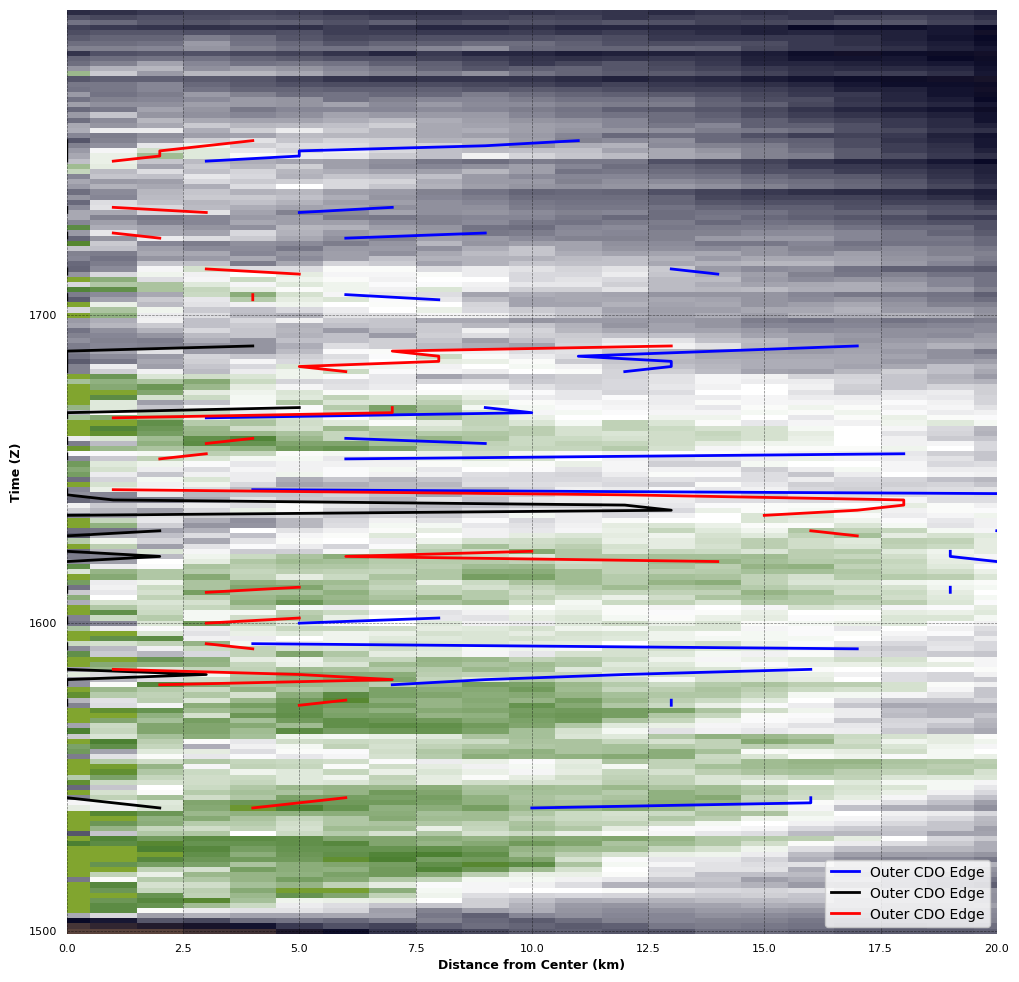

In [ ]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

data = allData[:, 0]

import satcmaps as cmaps
cmap = 'irg'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 20)

c = plt.pcolormesh(np.arange(0, len(data[0])), np.arange(0, len(data)), data, cmap = cmap, vmax = vmax, vmin = vmin)
# c = plt.contourf(np.arange(0, len(allData[0])), np.arange(0, len(allData)), allData, cmap = cmap, levels = np.arange(vmin, vmax + 1, 1))

plt.plot(cdoRad, np.arange(0, len(data)), color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(eyeRad, np.arange(0, len(data)), color = 'black', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(minRad, np.arange(0, len(data)), color = 'red', linewidth = 2, label = 'Outer CDO Edge')

plt.legend(loc = 'lower right')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Dorian', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'September 1-3rd, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Brightness Temperature (C)')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
plt.savefig(r"C:\Users\deela\Downloads\hovmollerIR.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

testData = np.diff(allData[:, 0], axis = 1)
print(testData.shape)

import cmaps as cmp
import satcmaps as cmaps
cmap = 'irg'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 150)
# ax.set_ylim(180, 240)

c = plt.pcolormesh(np.arange(0, len(testData[0])), np.arange(0, len(testData)), testData, cmap = cmp.tempAnoms3(), vmin = -10, vmax = 10)
# c = plt.contourf(np.arange(0, len(testData[0])), np.arange(0, len(testData)), testData, cmap = cmp.tempAnoms3(), levels = np.arange(-0.5, 0.505, .005), extend = 'both')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Radial Derivative')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerGrad.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
import cmaps as cmaps

data = allData[:, 0]

threshold = -60

yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

temp = np.where(data < threshold, data, np.nan)
temp = (np.nanmax(temp) - temp) / (np.nanmax(temp) - np.nanmin(temp))

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 150)

c = plt.pcolormesh(np.arange(0, len(temp[0])), np.arange(0, len(temp)), temp, cmap = cmaps.probs4(), vmax = 1, vmin = 0)

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Data < {threshold}C\nDeelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Normalized IR BT')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRFiltered.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
import cmaps as cmaps

data = allData[:, 0]

threshold = -75

yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

temp = data - np.nanmean(data, axis = 0)

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 200)

c = plt.pcolormesh(np.arange(0, len(temp[0])), np.arange(0, len(temp)), temp, cmap = cmaps.tempAnoms3(), vmax = 5, vmin = -5)

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Subtract Time Mean\nDeelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Normalized IR BT')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRTest.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
yLabels = [times[x] for x in range(len(times)) if x % 60 == 0]

data = allData[:, 1]

import cmaps as cmp
import satcmaps as cmaps
from scipy.ndimage import gaussian_filter

cmap = 'rbtop3'
cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

fig = plt.figure(figsize=(12, 12))

# Add the map and set the extent
ax = plt.axes()
ax.set_frame_on(False)

# Add state boundaries to plot
ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Distance from Center (km)', weight = 'bold', size = 9)
ax.set_ylabel('Time (Z)', weight = 'bold', size = 9)
ax.set_yticks(np.arange(0, len(times), 60))
ax.set_yticklabels(yLabels)
ax.set_xlim(0, 200)

# c = plt.pcolormesh(np.arange(0, len(allData[0])), np.arange(0, len(allData)), 1 / allData, cmap = cmp.probs4(), vmin = 0, vmax = 2.5)
c = plt.contourf(np.arange(0, len(data[0])), np.arange(0, len(data)), gaussian_filter(1 / data, sigma = 1), cmap = cmp.probs4(), levels = np.arange(0, 2.51, .01), extend = 'max')

plt.plot(cdoRad, np.arange(0, len(data)), color = 'blue', linewidth = 2, label = 'Outer CDO Edge')
plt.plot(eyeRad, np.arange(0, len(data)), color = 'white', linewidth = 2, label = 'Eye Radius')
plt.plot(minRad, np.arange(0, len(data)), color = 'red', linewidth = 2, label = 'Min. IR Temp')

plt.legend(loc = 'lower right')

ax.set_title(f'GOES-19 Band {band} Infrared Brightness Temperature Symmetry Hovmoller\nHurricane Melissa', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'October {day}th, {year}', fontsize=9, loc='center') 
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right') 
cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Inverse of the Standard Deviation of Each Ring')
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)
# plt.savefig(r"C:\Users\deela\Downloads\melissahovmollerIRSTD.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
maxSym = np.inf
maxRad = -np.inf
negTmp = np.inf
posTmp = -np.inf

t = 0
i = 0
for x in range(len(times)):
    if cdoStd[x] < maxSym and cdoRad[x] > maxRad and eyeTmp[x] > posTmp:
        maxSym = cdoStd[x]
        maxRad = cdoRad[x]
        negTmp = minTmp[x]
        posTmp = eyeTmp[x]
        t = times[x]
        i = x
print(t, 1 / maxSym, maxRad, negTmp, posTmp, bLon[i], bLat[i])